# Capital Dynamics in a Stochastic Growth Model

### Assignment 3 
- Tao Wang
- Feb 24, 2019

The handout [BrockMirman](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/DSGEmodels/BrockMirman) derived   some facts about a special case of a representative agent DSGE model where analytical results can be obtained.  This exercise asks you to explore this model and closely related ones further, numerically, by adapting tools from the [QuantEcon](https://lectures.quantecon.org/py/) treatment of [optimal growth](https://lectures.quantecon.org/py/optgrowth.html) (you should download their Jupyter notebook to get a start).

## PROBLEM
## Calculate theoretical variance of $k$
The handout shows that if the productivity shocks $\phi_{t}$ are iid and have variance $\sigma^{2}_{\phi}$ then

$$\newcommand{\var}{\text{var}}$$
\begin{eqnarray}
k_{t+1} & = & \log \alpha \beta + \alpha k_{t} + \phi_{t}
\end{eqnarray}

Show that this implies that the variance of $k$ is 
\begin{eqnarray}
 \var(k) & = & \frac{\sigma^{2}_{\phi}}{1-\alpha^{2}}
\end{eqnarray}

## ANSWERS

As $t\rightarrow +\infty$ 

\begin{eqnarray}
k = \log \alpha \beta + \alpha k +\phi
\end{eqnarray}

Taking variance on both sides,

\begin{eqnarray}
var(k) = \alpha^2 var(k) + \sigma^2_{\phi}
\end{eqnarray}

So,

\begin{eqnarray}
 \var(k) & = & \frac{\sigma^{2}_{\phi}}{1-\alpha^{2}}
\end{eqnarray}

### Preparations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
%matplotlib inline  
from quantecon import compute_fixed_point

In [2]:
## Define bellman operator 
## Copied from QuantEcon  

def bellman_operator(w, grid, β, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    β : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)   # It returns values of w at x based on values of w at grids. 

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)   # Generate an empty array in the same size of w values.

    if compute_policy:
        σ = np.empty_like(w) 

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):    # i and y are like two periods. 
        def objective(c):    
            return - u(c) - β * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            σ[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, σ
    else:
        return Tw
    
## Copied from QuantEcon

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^α

    with z ~ LN(μ, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, α=0.4, β=0.96, μ=0, s=0.1):

        self.α, self.β, self.μ, self.s = α, β, μ, s 

        # == Some useful constants == #
        self.ab = α * β
        self.c1 = np.log(1 - self.ab) / (1 - β)
        self.c2 = (μ + α * np.log(self.ab)) / (1 - α)
        self.c3 = 1 / (1 - β)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.α

    def f_prime(self, k):
        return self.α * k**(self.α - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.α * self.β) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)
    
## Set parameters

lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
α, β, μ, s = lg.α, lg.β, lg.μ, lg.s
v_star = lg.v_star

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(μ + s * np.random.randn(shock_size))

w = bellman_operator(v_star(grid),
                     grid,
                     β,
                     np.log,
                     lambda k: k**α,
                     shocks)

## Define baseline shocks: i.i.d. 
s = 0.05
shocks = np.exp(μ + s * np.random.randn(shock_size))


## Modified the simulate_og function to return not only series of income, but also capital stock.
## Copied from QuantEcon

def simulate_og_k(σ, y0 = 0.1, ts_length=100):
    '''
    Compute both time series of output and capital stock given consumption policy σ.
    '''
    y = np.empty(ts_length)
    cap = np.empty(ts_length)
    ξ = np.random.randn(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        cap[t] = y[t] - σ(y[t])  
        y[t+1] = (y[t] - σ(y[t]))**α * np.exp(μ + s * ξ[t])
    return y,cap

## PROBLEM
## Simulate the economy and calculate $\var(k)$

Now using the QuantEcon tools, simulate the economy under the baseline parameter values and show that your simulation results correspond to the theoretical result

## ANSWERS

In [46]:
n_sim =5
Tw = np.empty(len(grid))
initial_w= 5 * np.log(grid)
period = 50
β=0.96
kss_var_list=np.zeros(n_sim)

v_star_approx = compute_fixed_point(bellman_operator,
                                    initial_w,
                                    1e-5,        # error_tol
                                    period,      # max_iter
                                    False,       # verbose
                                    5,           # print_skip
                                    grid,
                                    β,
                                    np.log,
                                    lambda k: k**α,
                                    shocks,
                                    Tw=Tw,
                                    compute_policy=False)

Tw, σ = bellman_operator(v_star_approx,
                         grid,
                         β,
                         np.log,
                         lambda k: k**α,
                         shocks,
                         compute_policy=True)

σ_func = lambda x: np.interp(x, grid, σ)
for i in range(n_sim):
    y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock
    k_ss = np.average(k)   # steady state capital: average of 100
    kss_var = k.std()**2
    kss_var_list[i] =kss_var
print("The simulated variance of the steady state capital is "+str(kss_var.mean()))
print("The calculated variance of the steady state capital from equation above is "+ str(shocks.std()**2/(1-α**2)))

The simulated variance of the steady state capital is 0.00416028059796
The calculated variance of the steady state capital from equation above is 0.00291194856922


## PROBLEM
## Suppose $\phi_{t}$ is serially correlated

Now we want to consider a case where the level of productivity $\epsilon$ is serially correlated:

\begin{eqnarray}
\phi_{t} = \zeta \phi_{t-1} + \nu_{t}
\end{eqnarray}

for some shock $\nu$ with variance $\sigma^{2}_{\nu}$ and a serial correlation coefficient $0 < \zeta < 1$.  Calculate the variance of $k$ under this new assumption.

### ANSWERS

\begin{eqnarray}
var(\phi) = \xi^2 var(\phi)+\sigma^2_v
\end{eqnarray}


\begin{eqnarray}
var(\phi) = \frac{\sigma^2_v}{1-\xi^2}
\end{eqnarray}

Therefore, 

\begin{eqnarray}
var(k) = \frac{\sigma^2_v}{(1-\xi^2)(1-\alpha^2) }
\end{eqnarray}



## PROBLEM
## Now Solve and Simulate the Model

Use the tools provided on the QuantEcon website to solve the model.  Then, starting with a capital stock equal to the stochastic steady state, simulate the model for 100 periods five separate times.  Compare the variances you have calculated numerically to the formulas you derived analytically, and make some remarks about what this means for trying to calibrate the model to data by examining the variance of $k$ in empirical data.

### ANSWERS

In [8]:
## Define a function that generate AR1 serially correlated shocks
### period: number of peiords of shocks
### arcoeff: ar1 coefficient 
### size: mean of the i.i.d shock

def serialshocks(period,arcoeff,size):
    nb_discard = 10
    shocks = np.zeros(period+nb_discard)
    shocks[0] = np.random.randn(1)
    for i in range(period+nb_discard-1):
        shocks[i+1] = arcoeff*shocks[i]+size*np.random.randn(1)
    return shocks[nb_discard:,]

In [13]:
n_sim =5
Tw = np.empty(len(grid))
initial_w= 5 * np.log(grid)
period = 100
kss_var_list=np.zeros(n_sim)
s = 0.05

for ar_coeff in [0.1,0.5,0.8]:

    shocks = np.exp(serialshocks(shock_size,ar_coeff,s))   ## Redefined serially correlated shocks 

    v_star_approx = compute_fixed_point(bellman_operator,
                                        initial_w,
                                        1e-5,        # error_tol
                                        period,      # max_iter
                                        False,       # verbose
                                        5,           # print_skip
                                        grid,
                                        β,
                                        np.log,
                                        lambda k: k**α,
                                        shocks,
                                        Tw=Tw,
                                        compute_policy=False)

    Tw, σ = bellman_operator(v_star_approx,
                             grid,
                             β,
                             np.log,
                             lambda k: k**α,
                             shocks,
                             compute_policy=True)

    σ_func = lambda x: np.interp(x, grid, σ)
    for i in range(n_sim):
        y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock
        k_ss = np.average(k)   # steady state capital: average of 200 periods onward 
        kss_var = k.std()**2
        kss_var_list[i] =kss_var
    print("When AR(1) coefficient is "+str(ar_coeff)+": ")
    print("The simulated variance of the steady state capital is "+str(kss_var.mean()))
    print("The calculated variance of the steady state capital from equation above is "\
           + str(s**2/(1-ar_coeff**2)/(1-α**2)))

When AR(1) coefficient is 0.1: 
The simulated variance of the steady state capital is 0.00168599473165
The calculated variance of the steady state capital from equation above is 0.003006253006253007
When AR(1) coefficient is 0.5: 
The simulated variance of the steady state capital is 0.00152026450311
The calculated variance of the steady state capital from equation above is 0.003968253968253969
When AR(1) coefficient is 0.8: 
The simulated variance of the steady state capital is 0.00181838805965
The calculated variance of the steady state capital from equation above is 0.008267195767195772


## Now Do a Similar Exercise for the CRRA utility Model

Use the QuantEcon code to solve the model for a value of relative risk aversion $\rho = 3$.  Now calculate the variance of $k$ for this new model in the same way you did for the earlier model.  


### ANSWERS


In [14]:
## Now we modify the utility function to be 
    ## CRRA and simulate the model using four different coefficients of relative risk aversion

kss_list=[]
n_sim=5

shocks = np.exp(μ + s * np.random.randn(shock_size))  ## i.i.d shocks again 

for rho in [3]:
    
    def crra(c):
        return c**(1-rho)/(1-rho)  # CRRA Utility

    Tw = np.empty(len(grid))

    initial_w = 5 * crra(grid)
    
    period = 100

    v_star_approx = compute_fixed_point(bellman_operator,
                                        initial_w,
                                        1e-5,        # error_tol
                                        period,         # max_iter
                                        False,       # verbose
                                        5,           # print_skip
                                        grid,
                                        β,
                                        crra,    # replace with CRRA utility now
                                        lambda k: k**α,
                                        shocks,
                                        Tw=Tw,
                                        compute_policy=False)

    Tw, σ = bellman_operator(v_star_approx,
                             grid,
                             β,
                             crra,
                             lambda k: k**α,
                             shocks,
                             compute_policy=True)

    σ_func = lambda x: np.interp(x, grid, σ)
    for i in range(n_sim):
        y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock
        k_ss = np.average(k)   # steady state capital: average of 200 periods onward 
        kss_var = k.std()**2
        kss_var_list[i] =kss_var
print("The simulated variance of capital is "+str(kss_var.mean()))
print("The calculated variance of capital from equation above is "+ str(shocks.std()**2/(1-α**2)))

The simulated variance of the steady state capital is 0.00222002199074
The calculated variance of the steady state capital from equation above is 0.00291050218274


## Compare the Results to a linearized approximation

Now numerically confirm the result from the BrockMirman handout that 

\begin{eqnarray}
  y_{t+1} & = & \alpha (y_{t} + \log \alpha \beta ) + \phi_{t+1}
\end{eqnarray}

Simulations go here

### ANSWERS

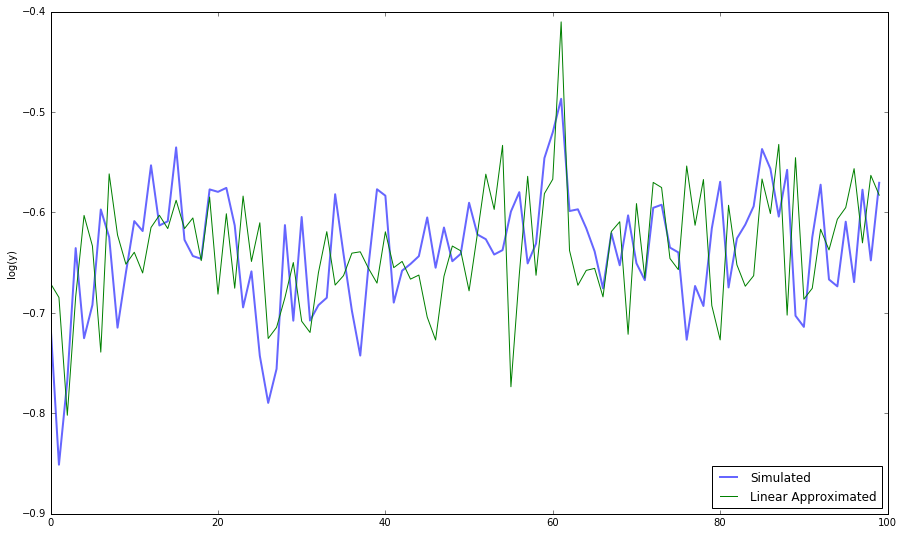

In [52]:
n_sim =5
Tw = np.empty(len(grid))
initial_w= 5 * np.log(grid)
period = 200

## i.i.d Shocks 
s = 0.05
shocks = np.exp(μ + s * np.random.randn(shock_size))

v_star_approx = compute_fixed_point(bellman_operator,
                                    initial_w,
                                    1e-5,        # error_tol
                                    period,      # max_iter
                                    False,       # verbose
                                    5,           # print_skip
                                    grid,
                                    β,
                                    np.log,
                                    lambda k: k**α,
                                    shocks,
                                    Tw=Tw,
                                    compute_policy=False)

Tw, σ = bellman_operator(v_star_approx,
                         grid,
                         β,
                         np.log,
                         lambda k: k**α,
                         shocks,
                         compute_policy=True)

σ_func = lambda x: np.interp(x, grid, σ)

y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock
y_ss = np.average(y)

## Plot the simulated series and approximate series of output 
log_y = np.log(y)

lapprox_y = np.zeros(period)
## Linear approximate 
for i in range(period-1):
    lapprox_y[i+1] =α*(log_y[i]+np.log(α*β))+s*np.random.randn(1)

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(log_y[100:,], lw=2, alpha=0.6, label="Simulated")
ax.plot(lapprox_y[100:,],label="Linear Approximated")
ax.set_ylabel('log(y)')
ax.legend(loc='lower right')

To develop the rest of this problem, see the corresponding question DSGE-RA-K-Dynamics-Problems-and-Solutions.  In particular, need to plot the phase diagram and show how the consumption function changes with $\rho$.

## Exercise 1 in Optimal Growth Lecture in [QuantEcon](https://lectures.quantecon.org/py/)

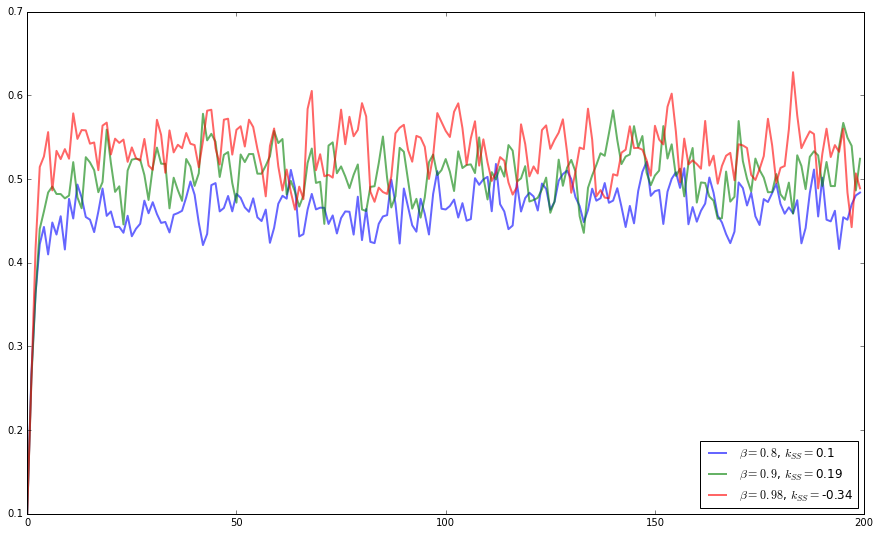

In [40]:
## Three different time preference rates

shocks = np.exp(μ + s * np.random.randn(shock_size))  ## i.i.d shocks again 

fig, ax = plt.subplots(figsize=(15, 9))

for β in [0.8, 0.9, 0.98]:

    Tw = np.empty(len(grid))
    initial_w = 5 * np.log(grid)
    period = 200

    v_star_approx = compute_fixed_point(bellman_operator,
                                        initial_w,
                                        1e-5,        # error_tol
                                        period,      # max_iter
                                        False,       # verbose
                                        5,           # print_skip
                                        grid,
                                        β,
                                        np.log,
                                        lambda k: k**α,
                                        shocks,
                                        Tw=Tw,
                                        compute_policy=False)

    Tw, σ = bellman_operator(v_star_approx,
                             grid,
                             β,
                             np.log,
                             lambda k: k**α,
                             shocks,
                             compute_policy=True)

    σ_func = lambda x: np.interp(x, grid, σ)
    y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock
    k_ss = np.average(k[100:,])   # steady state capital: average of 200 periods onward 
    ax.plot(y, lw=2, alpha=0.6, label=r'$\beta = {}$'.format(β)+', '+r'$k_{SS}=$'+str(round(k_ss,2)))


ax.legend(loc='lower right')